# 1) Import libraries and define global variables

In [1]:
import numpy as np
from tqdm import tqdm
import itertools
import plotly.graph_objects as go
import plotly.express as px



WORKERS_NB = 20 #number of workers
K_MIN = 10 #Minimum routes that can be created to pick up trash. K_MAX is actually WORKERS_NB

STREETS_NB = 100 #number of streets in the city with potential trash to collect
CLEAN_MAX = 70 #maximum streets that needs to be cleaned each week
CLEAN_MIN = 50 #minimum streets that needs to be cleaned each week

NB_WEEKS_SIM = 15 #number of weeks to simulate for the records

NB_WEEKS_AFTER = 15 #number of weeks to simulate after the records (for part 5)

GAMMA = 0.9 #discount factor -> how much we value the past

# 2) Functions to generate streets to clean, possible routes and matches with workers

In [2]:
def generate_streets():
    """
    Generate a random matrix of format STREETS_NB x 2 that contains the coordinates of the streets. The coordinates are floats between 0 and 100
    """
    city_map = np.random.rand(STREETS_NB, 2)*100

    #For each streets, calculate the distance to all other streets
    distances = np.zeros((STREETS_NB, STREETS_NB))

    for i in range(STREETS_NB):
        for j in range(STREETS_NB):
            if i != j:
                distances[i, j] = np.linalg.norm(city_map[i] - city_map[j])


    return city_map, distances



def generate_streets_to_clean():
    """
    Generate a random array of 0s and 1s of size STREETS_NB, where 1s represent the streets that need to be cleaned
    """
    n = np.random.randint(CLEAN_MIN, CLEAN_MAX + 1) #number of streets to clean

    streets = np.zeros(STREETS_NB)
    streets[:n] = 1 #Set the first n streets to 1, meaning they need to be cleaned
    np.random.shuffle(streets) #Shuffle the array to randomize the streets that need to be cleaned

    return streets


def generate_routes(streets, distances) :
    """
    Generate the routes for the workers to clean the streets. The routes are generated using a probabilistic approach, where the distance between the streets is used as a weight to assign the streets to the workers
    """

    workers_needed = np.random.randint(K_MIN, WORKERS_NB + 1) #number of workers needed to clean the streets
    routes = [[] for _ in range(workers_needed)] #List of routes for each worker

    #Get the index of the streets that need to be cleaned
    streets_to_clean = np.where(streets == 1)[0]
    np.random.shuffle(streets_to_clean)


    for i in range(len(streets_to_clean)):

        if i < workers_needed : #First, assign a street to each route so that each route has at least one street to clean
            routes[i].append(streets_to_clean[i])

        else : #For each route, take the distance to the closest routes and use it as a proba weight to assign the street to the route
            
            distance_vector = distances[streets_to_clean[i], :]
            proba_weight = [np.inf]*workers_needed

            for j in range(workers_needed):
                
                for k in routes[j]:
                    if distance_vector[k] < proba_weight[j]:
                        proba_weight[j] = distance_vector[k]

            
            proba_weight = np.array(proba_weight)
            #Normalize between 0 and 1
            proba_weight = proba_weight / np.sum(proba_weight)

            #Probabilistic assignment
            route_index = np.random.choice(range(workers_needed), p=proba_weight)
            routes[route_index].append(streets_to_clean[i])

    #Reorder the routes : use the Travelling salesman problem heuristic : nearest neighbor
    new_routes = []
    distances_travel = []
    for route in routes:
        new_route = []
        distance_traveled = 0
        for i in range(len(route)):
            if i == 0:
                new_route.append(route[0])
                route = np.delete(route, 0)
            else:
                distance_vector = distances[new_route[-1], route]
                next_street = np.argmin(distance_vector)
                new_route.append(route[next_street])
                route = np.delete(route, next_street)

                distance_traveled += distance_vector[next_street]

        new_routes.append(new_route)
        distances_travel.append(distance_traveled)

    return new_routes, distances_travel


def generate_match_workers(routes) :
    """
    """
    workers_match = [-1]*WORKERS_NB #-1 means that the worker is not matched with a route (they don't drive, stay at maintenance)
    workers_match[:len(routes)] = range(len(routes)) #The first workers are matched with a route
    np.random.shuffle(workers_match) #Shuffle the array to randomize the workers that are matched with a route

    routes_match = [0]*len(routes) #The number of workers matched with each route (reverse function of workers_match)
    for k in range(len(workers_match)):
        if workers_match[k] != -1:
            routes_match[workers_match[k]] += k
    
    return np.array(workers_match), np.array(routes_match )
        

street_map, distances = generate_streets()
streets_to_clean = generate_streets_to_clean()
generated_routes, distances_travel = generate_routes(streets_to_clean, distances)
workers_match, routes_match = generate_match_workers(generated_routes)


#### TEST PRINT ######
print("TEST generated routes <--> workers matched :\n")
for i, route in enumerate(generated_routes) : 
    print(f"{route} (distance of {round(distances_travel[i],2)}) <--> {routes_match[i]}")

#Get the index of workers_match that are equals to -1
maintenance_workers = np.where(np.array(workers_match) == -1)[0]
print(f"\nMaintenance workers : {maintenance_workers}")



TEST generated routes <--> workers matched :

[30, 78, 22, 71, 98, 50, 40] (distance of 204.02) <--> 9
[3, 27, 93, 33, 72] (distance of 221.62) <--> 1
[17, 77, 21, 86] (distance of 115.27) <--> 0
[63, 15, 94, 34, 66, 95] (distance of 186.99) <--> 12
[10, 20, 64, 7] (distance of 116.73) <--> 18
[42, 43] (distance of 37.91) <--> 10
[16, 26, 19, 5] (distance of 61.74) <--> 4
[88, 23, 92, 4, 13, 79] (distance of 218.46) <--> 19
[73, 6, 28, 39, 45, 75] (distance of 184.51) <--> 13
[12, 14] (distance of 27.74) <--> 2
[51, 81, 76, 96, 65] (distance of 156.79) <--> 15
[57, 44, 85, 69] (distance of 98.85) <--> 7
[59, 84, 67] (distance of 105.86) <--> 8
[49, 90, 60, 18, 58, 24, 0] (distance of 225.27) <--> 3

Maintenance workers : [ 5  6 11 14 16 17]


# 3) Creation of route-assignment records

### Create the city

In [3]:
street_map, distances = generate_streets()

### Simulate `NB_WEEKS_SIM` weeks

In [4]:
simulated_weeks = [] #List of weeks simulated [{streets_to_clean, generated_routes, distances_travel, workers_match, routes_match}, ...]
#streets_to_clean = [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0] -> 1 when the street needs to be cleaned
#generated_routes = [[1, 2, 4, 6, 8, 10, 12, 14, 16, 18], [0, 3, 5, 7, 9, 11, 13, 15, 17, 19]] -> list of routes (route are sequence of streets to clean)
#distances_travel = [12.3, 15.2] -> distance to travel for each route of generated_routes
#workers_match = [1, -1, 0, -1, -1] -> index of the route that the worker is matched with. -1 means that the worker is not matched with a route (they don't drive, stay at maintenance)
#routes_match = [2, 0] -> index of workers matched with each route (reverse function of workers_match)


for i in tqdm(range(NB_WEEKS_SIM), desc="Simulating weeks..."):

    week_info = {}

    streets_to_clean = generate_streets_to_clean()
    generated_routes, distances_travel = generate_routes(streets_to_clean, distances)
    workers_match, routes_match = generate_match_workers(generated_routes)

    week_info["streets_to_clean"] = streets_to_clean
    week_info["generated_routes"] = generated_routes
    week_info["distances_travel"] = distances_travel
    week_info["workers_match"] = workers_match
    week_info["routes_match"] = routes_match

    simulated_weeks.append(week_info)


def retrieve_info(simulated_weeks):
    """
    Calculate information about the simulation of each worker
    """
    info = {}
    sim_week = len(simulated_weeks)
    for i in tqdm(range(sim_week), desc="Retrieving information..."):
        for w in range(WORKERS_NB):
            route_of_worker = simulated_weeks[i]["workers_match"][w]
            if route_of_worker != -1: #Not in maintenance
                
                #INFORMATION TO RETRIEVE
                driving_index = GAMMA**(sim_week - i)
                total_distance = simulated_weeks[i]["distances_travel"][route_of_worker]

                if w not in info: #Initialize the info
                    info[w] = {"driving_index": 0, "total_distance": 0, "visited_streets": {}}

                info[w]["driving_index"] += driving_index
                info[w]["total_distance"] += total_distance
                if i >= sim_week - 3 : #If the week is in the last 3 weeks, store the visited streets
                    info[w]["visited_streets"][sim_week - i] =  simulated_weeks[i]["generated_routes"][route_of_worker]

    return info

info = retrieve_info(simulated_weeks)
print("\n\nINFO :")
for w in info:
    print(f"Worker {w} : {info[w]}")

Retrieving information...: 100%|██████████| 15/15 [00:00<00:00, 133860.77it/s]



INFO :
Worker 0 : {'driving_index': 4.95109493322526, 'total_distance': 1299.9015086131901, 'visited_streets': {3: [14, 59, 5, 49], 1: [79, 81, 74, 76, 73, 19, 6]}}
Worker 2 : {'driving_index': 6.24697981114816, 'total_distance': 1521.890076847361, 'visited_streets': {3: [74, 86, 51, 12, 77], 2: [54, 21, 1, 74]}}
Worker 3 : {'driving_index': 5.76868291114816, 'total_distance': 1422.1629151029736, 'visited_streets': {3: [32, 83, 72], 2: [62, 81]}}
Worker 4 : {'driving_index': 4.1452587260581595, 'total_distance': 1104.304440605989, 'visited_streets': {3: [18]}}
Worker 5 : {'driving_index': 5.16733131505816, 'total_distance': 1241.7063921238753, 'visited_streets': {3: [7, 73], 2: [9, 67], 1: [28, 56, 83, 63, 84]}}
Worker 6 : {'driving_index': 5.85955932214816, 'total_distance': 1409.9215089385689, 'visited_streets': {3: [95, 62], 2: [18, 44]}}
Worker 7 : {'driving_index': 4.10611862931526, 'total_distance': 1273.7953875335081, 'visited_streets': {3: [39], 2: [27, 90, 0]}}
Worker 8 : {'

# 4) Apply our trees for next week

### Get next week's routes

In [5]:
streets_to_clean = generate_streets_to_clean()
generated_routes, distances_travel = generate_routes(streets_to_clean, distances)

maintenance_number = WORKERS_NB - len(generated_routes)


#Put the info in a list of dict [{streets_sequence, distance}] for each routes
info_routes = {}
for i, route in enumerate(generated_routes):
    info_routes[i] = {"streets_sequence": route, "distance": distances_travel[i]}



print(f"Maintenance workers : {maintenance_number}\n")

print("Next week routes :\n")
for i, route in enumerate(generated_routes) : 
    print(f"{route} (distance of {round(distances_travel[i],2)})")

Maintenance workers : 7

Next week routes :

[99, 48, 87, 65, 77, 93] (distance of 209.78)
[69, 56, 19, 58, 96, 40] (distance of 208.11)
[29, 84, 57, 80, 5] (distance of 162.59)
[95, 16, 78, 61, 76, 45] (distance of 217.15)
[60, 66, 17, 53, 41, 68] (distance of 216.86)
[89, 39, 55, 28] (distance of 150.12)
[86] (distance of 0)
[15, 30, 27, 6] (distance of 96.29)
[0, 1, 22, 24, 33, 23] (distance of 171.76)
[9, 20, 42, 11] (distance of 150.16)
[21, 72, 10, 38, 75] (distance of 164.96)
[98, 18, 35, 74] (distance of 122.03)
[34, 3, 47] (distance of 97.88)


### First tree : determine who drives

In [6]:
def first_tree(info, maintenance_number, verbose = True):
    
    #FIRST BRANCH : Take the top 2*maintenance_number workers with the highest driving_index
    info_driving_sort = dict(sorted(info.items(), key=lambda item: item[1]["driving_index"], reverse=True))
    top_workers = list(info_driving_sort.keys())[:2*maintenance_number]
    info_top_workers = {k: info[k] for k in top_workers}

    #SECOND BRANCH : Take the top maintenance_number workers with the highest total_distance of the remaining workers
    info_distance_sort = dict(sorted(info_top_workers.items(), key=lambda item: item[1]["total_distance"], reverse=True))
    top_workers = list(info_distance_sort.keys())[:maintenance_number]
    info_top_workers = {k: info[k] for k in top_workers}

    #Create the driving worker dictionnary
    driving_workers = { k: info[k] for k in info if k not in top_workers}

    if verbose : 
        print("Selected workers for maintenance for next week :")
        for w in info_top_workers:
            print(f"Worker {w} : {info_top_workers[w]}")

        print("\nSelected workers for driving for next week :")
        for w in driving_workers:
            print(f"Worker {w} : {driving_workers[w]}")

    return driving_workers

### Second tree : one line tree where each node is test for a route assignment

In [7]:
def second_tree(driving_workers, info_routes):

    #Sort driving workers by distance (descending)
    driving_workers_sort = dict(sorted(driving_workers.items(), key=lambda item: item[1]["total_distance"], reverse=True))


    #Sort the info_routes to clean by distance (ascending)
    info_routes_sort = dict(sorted(info_routes.items(), key=lambda item: item[1]["distance"], reverse=False))


    assert len(info_routes_sort) == len(driving_workers_sort), "The number of routes to clean and the number of driving workers should be the same"

    #Assign the routes to the driving workers
    worker_match = [-1]*WORKERS_NB
    for i, idx_driver in enumerate(driving_workers_sort):

        for j, idx_route in enumerate(info_routes_sort):
            visited_streets_last_3_weeks = itertools.chain.from_iterable(driving_workers_sort[idx_driver]["visited_streets"].values())
            if not(  set(visited_streets_last_3_weeks) & set(info_routes_sort[idx_route]["streets_sequence"]) ) or j == len(info_routes_sort) - 1: #If the worker has not visited a streets of the route
                assign_route = idx_route #Assign the route to the worker
                break
            
        worker_match[idx_driver] = assign_route

        #delete the route from the info_routes_sort
        del info_routes_sort[assign_route]
        

    return worker_match


### Run the two trees

In [8]:
print("#"*20 + " FIRST TREE " + "#"*20)
driving_workers = first_tree(info, maintenance_number)

print("\n\n" + "#"*20 + " SECOND TREE " + "#"*20)
worker_match = second_tree(driving_workers, info_routes)
print("Worker match : ", worker_match)

#################### FIRST TREE ####################
Selected workers for maintenance for next week :
Worker 1 : {'driving_index': 6.462791779053511, 'total_distance': 2086.8594929182855, 'visited_streets': {3: [70, 89, 11], 2: [24, 16, 46, 8, 11], 1: [13, 39, 88, 75, 80, 99, 53]}}
Worker 14 : {'driving_index': 6.556489811148161, 'total_distance': 1765.2694991459157, 'visited_streets': {3: [37, 63], 2: [23, 10, 69, 42, 39, 92, 66], 1: [42, 15, 85, 90, 50, 97]}}
Worker 16 : {'driving_index': 6.833169215058161, 'total_distance': 1734.5936962714993, 'visited_streets': {3: [0, 46], 2: [78, 31, 5, 58], 1: [11, 12, 30, 20]}}
Worker 12 : {'driving_index': 5.900389811148161, 'total_distance': 1612.02645932464, 'visited_streets': {3: [23, 85, 31], 2: [35, 47, 70, 75, 3], 1: [33, 23, 1, 41, 35, 93, 70, 3]}}
Worker 9 : {'driving_index': 6.0410886790535105, 'total_distance': 1540.8353587167114, 'visited_streets': {3: [68, 13, 34], 2: [15, 49]}}
Worker 18 : {'driving_index': 5.900389811148161, 'tot

# 5) Loop on several weeks to check the performance of the our model

Now that we have a proof of concept, let's try to apply our model on several weeks after

In [9]:
def run_one_week(info, distances) :

    #Generate the new routes for the week
    streets_to_clean = generate_streets_to_clean()
    generated_routes, distances_travel = generate_routes(streets_to_clean, distances)

    maintenance_number = WORKERS_NB - len(generated_routes)


    #Put the info in a list of dict [{streets_sequence, distance}] for each routes
    info_routes = {}
    for i, route in enumerate(generated_routes):
        info_routes[i] = {"streets_sequence": route, "distance": distances_travel[i]}

    #First tree
    driving_workers = first_tree(info, maintenance_number, verbose=False)

    #Second tree
    worker_match = second_tree(driving_workers, info_routes)

    #Update the info
    for w in info:
        info[w]["driving_index"] *= GAMMA
        info[w]["visited_streets"] = {k + 1 : v for k,v in info[w]["visited_streets"].items() if k < 3}

        if w in driving_workers:
            route_assigned = worker_match[w]
            info[w]["driving_index"] += GAMMA
            info[w]["total_distance"] += distances_travel[route_assigned]
            info[w]["visited_streets"][1] = generated_routes[route_assigned]



    return info

In [10]:
#########################################
######### SOME PLOT VARIABLES ###########
#########################################
total_distance_evolution = [ [0] for w in info ]
street_0 = [] #Track who visited street 0



#########################################
########## CREATE THE CITY MAP ########## 
#########################################
street_map, distances = generate_streets()



#########################################
###### SIMULATE NB_WEEKS_SIM WEEKS ###### 
#########################################
simulated_weeks = []
for i in tqdm(range(NB_WEEKS_SIM), desc="Simulating weeks..."):

    week_info = {}

    streets_to_clean = generate_streets_to_clean()
    generated_routes, distances_travel = generate_routes(streets_to_clean, distances)
    workers_match, routes_match = generate_match_workers(generated_routes)

    week_info["streets_to_clean"] = streets_to_clean
    week_info["generated_routes"] = generated_routes
    week_info["distances_travel"] = distances_travel
    week_info["workers_match"] = workers_match
    week_info["routes_match"] = routes_match

    simulated_weeks.append(week_info)

    #Update some plot variables
    zero_has_been_visited = False
    for i, w in enumerate(workers_match):
        #Update the total distance evolution
        total_dist = total_distance_evolution[i][-1]
        if w != -1:
            total_dist += week_info["distances_travel"][week_info["workers_match"][i]]
        total_distance_evolution[i].append(total_dist)

        #Update the street 0
        if w != -1 and 0 in week_info["generated_routes"][week_info["workers_match"][i]]:
            street_0.append(i)
            zero_has_been_visited = True
    if not zero_has_been_visited:
        street_0.append(-1)


info = retrieve_info(simulated_weeks)



#########################################
######### RUN THE SIMULATION ############
#########################################
for i in tqdm(range(NB_WEEKS_AFTER), desc="Running simulation..."):
    info = run_one_week(info, distances)

    #Update some plot variables
    zero_has_been_visited = False
    for w in info:
        #Update the total distance evolution
        total_distance_evolution[w].append(info[w]["total_distance"])

        #Update the street 0
        if 1 in info[w]["visited_streets"] and 0 in info[w]["visited_streets"][1] and not zero_has_been_visited :
            street_0.append(w)
            zero_has_been_visited = True
    if not zero_has_been_visited:
        street_0.append(-1)


print("\n\nINFO :")
for w in info:
    print(f"Worker {w} : {info[w]}")

Simulating weeks...:   0%|          | 0/15 [00:00<?, ?it/s]

Running simulation...: 100%|██████████| 15/15 [00:00<00:00, 718.73it/s]



INFO :
Worker 1 : {'driving_index': 6.234585030207322, 'total_distance': 2924.8524048633726, 'visited_streets': {3: [9, 5, 25, 78], 2: [48, 50, 21]}}
Worker 3 : {'driving_index': 5.9385650790090345, 'total_distance': 2984.5569922675454, 'visited_streets': {3: [17, 41, 82, 44, 61], 2: [98, 96, 47]}}
Worker 4 : {'driving_index': 6.750291621487665, 'total_distance': 3016.5907243462566, 'visited_streets': {3: [64, 42, 33], 1: [3, 8, 77, 89, 22]}}
Worker 6 : {'driving_index': 6.8671639563322895, 'total_distance': 3034.9799437651577, 'visited_streets': {3: [36, 48, 77], 1: [83, 75, 79, 72, 78, 39]}}
Worker 8 : {'driving_index': 6.710875290530914, 'total_distance': 2974.290131943077, 'visited_streets': {3: [98, 20], 1: [19, 28, 42, 1]}}
Worker 11 : {'driving_index': 5.943066726045899, 'total_distance': 2952.217800785999, 'visited_streets': {3: [72, 27, 35, 54], 2: [51, 31, 86, 81, 62]}}
Worker 13 : {'driving_index': 7.46897284294817, 'total_distance': 3071.6630727231714, 'visited_streets': 

### Some plots

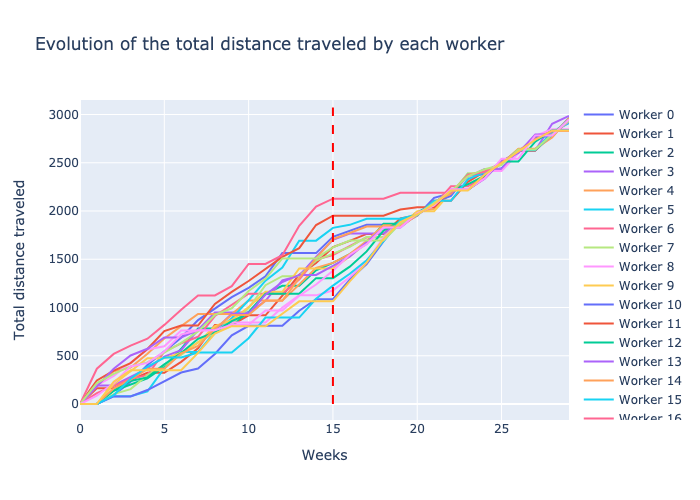

In [11]:
# Evolution of the total distance traveled by each worker
fig = go.Figure()
for i in range(WORKERS_NB):
    #trace the line 
    fig.add_trace(go.Scatter(x=list(range(NB_WEEKS_SIM + NB_WEEKS_AFTER)), y=total_distance_evolution[i], mode='lines', name=f"Worker {i}"))

#Add a horizontal line for x = NB_WEEKS_SIM
fig.add_shape(type='line',
              x0=NB_WEEKS_SIM, y0=0,
              x1=NB_WEEKS_SIM, y1=max([max(distances) for distances in total_distance_evolution]),
              line=dict(color='Red', width=2, dash='dash'))



fig.update_layout(title='Evolution of the total distance traveled by each worker', xaxis_title='Weeks', yaxis_title='Total distance traveled')
fig.show("png")






In [12]:
#### Who visited street 0 ?
print("DURING THE SIMULATION, WHO VISITED STREET 0 ?")
string_print = ""
for i, w in enumerate(street_0[:NB_WEEKS_SIM]):
    if i != 0 :
        string_print += " -> "
    
    if w != -1:
        string_print += f"{w}"
    else:
        string_print += "//"

print(string_print)

print("\n\nAFTER THE SIMULATION, WHO VISITED STREET 0 ?")
string_print = ""
for i, w in enumerate(street_0[NB_WEEKS_SIM:]):
    if i != 0 :
        string_print += " -> "
    
    if w != -1:
        string_print += f"{w}"
    else:
        string_print += "//"
print(string_print)


DURING THE SIMULATION, WHO VISITED STREET 0 ?
4 -> 13 -> 18 -> // -> 18 -> // -> 2 -> 10 -> 7 -> // -> // -> 16 -> // -> 4 -> //


AFTER THE SIMULATION, WHO VISITED STREET 0 ?
18 -> // -> // -> 6 -> // -> 17 -> // -> 16 -> // -> // -> // -> 6 -> // -> 13 -> 16
